In [1]:
import numpy as np
import scipy.linalg
from control import dlqr
import matplotlib.pyplot as plt
import control
import time
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
def generate_perturbed_samples(A, N, epsilon, symmetric = None):
    """
    Generates N samples that are perturbed from matrix A,
    such that the maximum spectral norm difference between all pairs
    is less than epsilon.

    Parameters:
    A (np.ndarray): The original matrix.
    N (int): The number of samples to generate.
    epsilon (float): The maximum allowed spectral norm difference.
    flag (boolean): Check Q is symmetric.

    Returns:
    List[np.ndarray]: A list of perturbed samples.
    """
    # Compute the spectral norm of the original matrix
    norm_A = np.linalg.norm(A, ord=2)

    # Initialize a list to hold the perturbed samples
    perturbed_samples =[]
    perturbed_samples.append(A)

    # Generate N-1 perturbed samples
    for _ in range(N-1):
        while True:
            # Generate a random perturbation matrix
            P = np.random.randn(*A.shape)

            # If symmetric flag is set, make P a symmetric matrix
            if symmetric:
                P = (P + P.T) / 2

            # Scale the perturbation matrix to have a spectral norm of epsilon
            norm_P = np.linalg.norm(P, ord=2)
            P_scaled = (P / norm_P) * epsilon  * 0.6#*  (2/3 + 1/3 *(np.random.rand()  # Random scaling factor less than epsilon

            # Add the perturbation to the original matrix
            A_perturbed = A + P_scaled

            # Ensure that the new sample's spectral norm difference is less than epsilon
            if all(np.linalg.norm(A_perturbed - other_A, ord=2) < epsilon for other_A in perturbed_samples):
                perturbed_samples.append(A_perturbed)
                break  # The perturbed sample is valid, break the loop

    # perturbed_samples = perturbed_samples[1:]

    return perturbed_samples



def grad_zo(A, B, Q, R, K, U, r, x_0, N):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_emp1 = []
    cost_emp2 = []
    grad = np.zeros((nu, nx))
    U1 = []

    for i in range(U.shape[0]):
        # Sample policies
        # Check stability
        #if check_stable(A, B, K + U[i]) == True and check_stable(A, B, K - U[i]) == True:
        K1.append(K + U[i])
        K2.append(K - U[i])
        U1.append(U[i])

        # Compute empirical cost
        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        cost_emp1.append(generate_task.lqr_cost(A, B, Q, R, K1[-1], x_0, N))
        cost_emp2.append(generate_task.lqr_cost(A, B, Q, R, K2[-1], x_0, N))

    ns = len(cost_emp1)
    for i in range(ns):
        grad += ((nx * nu) / (2 * ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * U1[i]

    return grad


def hessian_zo(A, B, Q, R, K, U, r, x_0, N):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_emp1 = []
    cost_emp2 = []
    hess = np.zeros((nu, nu))
    U1 = []

    for i in range(U.shape[0]):
        # Sample policies
        # Check stability
        #if check_stable(A, B, K + U[i]) == True and check_stable(A, B, K - U[i]) == True:
        K1.append(K + U[i])
        K2.append(K - U[i])
        U1.append(U[i])

        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        # Compute empirical cost
        cost_emp1.append(generate_task.lqr_cost(A, B, Q, R, K1[-1], x_0, N))
        cost_emp2.append(generate_task.lqr_cost(A, B, Q, R, K, x_0, N))

    ns = len(cost_emp1)
    for i in range(ns):
        U_i = U1[i] @ U1[i].T
        #hess += ((nu * nu) / (2 * ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * (U_i - np.eye(U_i.shape[0]))
        hess += ((nu * nu) / (ns * (r ** 2))) * (cost_emp1[i] - cost_emp2[i]) * (U_i - np.eye(U_i.shape[0]))

    return hess

class generate_task:
    def __init__(self, A, B, Q, R, M = None, flag = None, param = None, N = None):
        """
        Initialize the Discrete Time State Space system with LQR cost function.

        Parameters:
        A (np.ndarray): State transition matrix.
        B (np.ndarray): Control matrix.
        Q (np.ndarray): State cost matrix.
        R (np.ndarray): Control cost matrix.
        M (int): Number of tasks.
        flag (str): 's': system heterogeneity, 'c': cost heterogeneity, 'sc': system & cost heterogeneity.
        param (list): [ep1, ep2], [ep3,ep4], [ep1,ep2,ep3,ep4]. Heterogeneity
        N (int): Horizon.
        """
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.M = M

        if flag == 's':
            self.A_M = generate_perturbed_samples(A, M, param[0])
            self.B_M = generate_perturbed_samples(B, M, param[1])
            self.Q_M = [Q for _ in self.A_M]
            self.R_M = [R for _ in self.A_M]

        elif flag == 'c':
            self.Q_M = generate_perturbed_samples(Q, M, param[0], 1)
            self.R_M = generate_perturbed_samples(R, M, param[1], 1)
            self.A_M = [A for _ in self.Q_M]
            self.B_M = [B for _ in self.Q_M]

        else: # s & c
            self.A_M = generate_perturbed_samples(A, M, param[0])
            self.B_M = generate_perturbed_samples(B, M, param[1])
            self.Q_M = generate_perturbed_samples(Q, M, param[0], 1)
            self.R_M = generate_perturbed_samples(R, M, param[1], 1)

    def K_star(self):
        K = []
        for i, item in enumerate(self.A_M):
            k, _, _ = dlqr(item, self.B_M[i], self.Q_M[i], self.R_M[i])
            K.append(np.array(k))
        self.K_star = K

    @staticmethod
    def control_law(K, x_t):
        if K is None:
            raise ValueError("LQR solution not computed. Call K_star() first.")
        return -K @ x_t

    @staticmethod
    def simulate(A, B, N, x0):
        x_t = x0.copy()
        states = [x_t]
        # controls = []
        for i in range(N):
            u_t = generate_task.control_law(K, x_t)
            # controls.append(u_t)
            x_t = A @ x_t + B @ u_t
            states.append(x_t)
        return states   #, controls

    @staticmethod
    def lqr_cost(A, B, Q, R, K, x_0, N):
        """
        Computes the LQR cost for a given sequence of states up to a horizon N,
        using the state cost matrix Q, the control cost matrix R, and the
        feedback gain matrix K.

        Parameters:
        Q (np.ndarray): The state cost matrix.
        R (np.ndarray): The control cost matrix.
        K (np.ndarray): The feedback gain matrix.
        x_list (List[np.ndarray]): The list of state vectors.
        N (int): The horizon up to which to compute the cost.

        Returns:
        float: The computed LQR cost.
        """
    
        pk = Q.copy()
        for t in range(N + 1):
            pk = Q + K.T @ R @ K + (A - B @ K).T @ pk @ (A - B @ K)
        cost = x_0 @ pk @ x_0
        return cost

    def init_k(self, perturb, step):
        k, _, _ = dlqr(self.A, self.B, self.Q, self.R)
        k = np.array(k)
        noise = np.random.normal(0, 1, k.shape)

        # Normalize the noise vector so its norm is 1
        noise = (noise / np.linalg.norm(noise)) * perturb
        k_p = k + noise
        flag_k = check_stable(self.A ,self.B, k)
        while flag_k == False:
            flag_k = check_stable(self.A ,self.B, k + np.random.normal(0, perturb, k.shape))
        flag_task = False
      
        while flag_task == False:
            flag = []
            for i in range(len(self.A_M)):
                ki = k_p - step * grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], k_p)
                flag.append(check_stable(self.A_M[i], self.B_M[i], ki))

            flag_task = all(flag)

        return k_p, k

    def C_star(self, x_0, N): # N - horizon
        C = []
        for i, item in enumerate(self.A_M):
            cost = generate_task.lqr_cost(item, self.B_M[i], self.Q_M[i], self.R_M[i], self.K_star[i], x_0, N)
            C.append(cost)
        return C

    def MAML(self, K, ita1, ita2):
        sum1 = np.zeros((K.shape))
        for i in range(len(self.A_M)):
            K_1 = K - ita2 * grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K)
            grad = grad_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K_1)
            hess = hessian_true(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K)
            hess = np.eye(hess.shape[0]) - ita2 * hess
            sum1 += hess@grad
        step = - ita1 * (1/self.M) * sum1
        K_MAML = K + step
        return K_MAML

    def MAML_ZO(self, K, ita1, ita2, r, sample, x_0, N):
        sum1 = np.zeros((K.shape))
        U = np.random.randn(sample, self.B.shape[1], self.A.shape[0])
        U_norms = np.linalg.norm(U, axis=(1, 2), keepdims=True)
        U = (U / U_norms)* r
    
        for i in range(len(self.A_M)):
            K_1 = K - ita2 * grad_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K, U, r, x_0, N)
            grad = grad_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K_1, U, r, x_0, N)
            hess = hessian_zo(self.A_M[i], self.B_M[i], self.Q_M[i], self.R_M[i], K, U, r, x_0, N)
            hess = np.eye(hess.shape[0]) - ita2 * hess
            sum1 += hess @ grad
        step = - ita1 * (1/self.M) * sum1
        K_MAML = K + step
        return K_MAML



    def C_MAML(self, K, x_0, N): # N - horizon
        C = []
        for i, item in enumerate(self.A_M):
            cost = generate_task.lqr_cost(item, self.B_M[i], self.Q_M[i], self.R_M[i], K, x_0, N)
            C.append(cost)
        return C

In [3]:
#MAML - Convergence - Modified Boeing system 


AA = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])
BB = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])
QQ = np.eye(4)
RR = np.eye(2)
nx = AA.shape[0]
nu = BB.shape[1]
eta = 0.8e-5
eta_l = 0.8e-5
x_0 = np.array([0.25,0.55,0.35,0.45])
iteration = 200
ep = [0.01,0.01]
horizon = 500
setting = 'sc'
M = 10
r = 0.01
sample = 20
a = generate_task(AA,BB,QQ,RR,M,setting,ep)

$\textbf{Checking the true heterogeneity:}$

In [4]:
norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(a.A_M[p] - a.A_M[s]))
        norm_2.append(np.linalg.norm(a.B_M[p] - a.B_M[s]))
        norm_3.append(np.linalg.norm(a.Q_M[p] - a.Q_M[s]))
        norm_4.append(np.linalg.norm(a.R_M[p] - a.R_M[s]))

dis1 = ["eps1=", max(norm_1)]
dis2 = ["eps2=", max(norm_2)]
dis3 = ["eps3=", max(norm_3)]
dis4 = ["eps4=", max(norm_4)]

print(dis1)
print(dis2)
print(dis3)
print(dis4)

['eps1=', 0.012525508573933704]
['eps2=', 0.010652866176920031]
['eps3=', 0.013754219667630982]
['eps4=', 0.010050841940075906]


In [5]:
C_opt = [i for i in range(iteration)]
C_MAML_All = []

K_opt_nominal,_,_ = dlqr(AA, BB, QQ, RR)
x0 = x_0
C_opt = generate_task.lqr_cost(AA, BB, QQ, RR, K_opt_nominal,x_0, horizon)

#Perturbing K_opt_nominal to generate the initial controller 
# KK = K_opt_nominal + 0.22 * np.random.rand(nu, nx)
K0 = np.array([[ 0.61343269, -1.53543838,  0.30279836,  0.39631415],
              [ 0.88802018,  0.60382034, -0.14729954, -0.58220629]])
C1 = generate_task.lqr_cost(AA, BB, QQ, RR, K0,x_0, 1000)

In [6]:
a.C_MAML(K0, x0, horizon)

[22.546370377402766,
 22.314040409597524,
 28.985749346155558,
 22.981727757007953,
 20.91296453627138,
 23.013042475987266,
 21.655613023978752,
 24.330601918271036,
 23.49900192617278,
 24.960931659215547]

In [7]:
def MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration):
    C_MAML_ZO = []
    KK = K0
    C_MAML_ZO.append((a.C_MAML(KK, x0, horizon)[0] - C_opt))
    print(f"Iteration: {0}, Normalized cost gap: {C_MAML_ZO[0]}")
    for n in range(iteration):
        start_time = time.time()
        K11 = a.MAML_ZO(KK,eta,eta_l, r, sample, x0, horizon)
        KK = K11
        end_time = time.time()
        C_MAML_ZO.append((a.C_MAML(KK, x0, horizon)[0] - C_opt))        
        print(f"Iteration: {n+1}, Normalized cost gap: {C_MAML_ZO[n+1]}, Time: {end_time - start_time}")
    return C_MAML_ZO, KK

$\textbf{Varying heterogeneity:}$

In [9]:
iteration = 500

In [10]:
eta = 0.8e-5
eta_l = 0.8e-5
eps1 = [0.001,0.001]
r = 0.01
sample = 20
a = generate_task(AA,BB,QQ,RR,M,setting,eps1)
norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(a.A_M[p] - a.A_M[s]))
        norm_2.append(np.linalg.norm(a.B_M[p] - a.B_M[s]))
        norm_3.append(np.linalg.norm(a.Q_M[p] - a.Q_M[s]))
        norm_4.append(np.linalg.norm(a.R_M[p] - a.R_M[s]))

dis1 = ["eps1=", max(norm_1)]
dis2 = ["eps2=", max(norm_2)]
dis3 = ["eps3=", max(norm_3)]
dis4 = ["eps4=", max(norm_4)]

print(dis1)
print(dis2)
print(dis3)
print(dis4)

C_opt = [i for i in range(iteration)]
C_MAML_All = []

K_opt_nominal,_,_ = dlqr(AA, BB, QQ, RR)
x0 = x_0
C_opt = generate_task.lqr_cost(AA, BB, QQ, RR, K_opt_nominal,x_0, horizon)

#Perturbing K_opt_nominal to generate the initial controller 
# KK = K_opt_nominal + 0.22 * np.random.rand(nu, nx)
K0 = np.array([[ 0.61343269, -1.53543838,  0.30279836,  0.39631415],
              [ 0.88802018,  0.60382034, -0.14729954, -0.58220629]])
C1 = generate_task.lqr_cost(AA, BB, QQ, RR, K0,x_0, 1000)

[costs_1,_] = MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration)

['eps1=', 0.0013385962065776134]
['eps2=', 0.0011072450059082823]
['eps3=', 0.0013177247236255876]
['eps4=', 0.0011802674999808398]
Iteration: 0, Normalized cost gap: 19.83157578520511
Iteration: 1, Normalized cost gap: 12.54780701595774, Time: 2.787425994873047
Iteration: 2, Normalized cost gap: 10.182427326613116, Time: 2.773080825805664
Iteration: 3, Normalized cost gap: 6.921393375567287, Time: 2.769223213195801
Iteration: 4, Normalized cost gap: 5.4297401604797, Time: 2.7662439346313477
Iteration: 5, Normalized cost gap: 4.692317989612931, Time: 2.7698590755462646
Iteration: 6, Normalized cost gap: 4.296210236533923, Time: 2.8049850463867188
Iteration: 7, Normalized cost gap: 3.9958089051934254, Time: 2.8281517028808594
Iteration: 8, Normalized cost gap: 3.7108337994536837, Time: 2.7779440879821777
Iteration: 9, Normalized cost gap: 3.4066275522692395, Time: 2.8171520233154297
Iteration: 10, Normalized cost gap: 3.168410324577028, Time: 2.7810449600219727
Iteration: 11, Normalized

Iteration: 134, Normalized cost gap: 0.39658524315679067, Time: 2.857142925262451
Iteration: 135, Normalized cost gap: 0.39191828850307164, Time: 2.848583936691284
Iteration: 136, Normalized cost gap: 0.3867099965726055, Time: 2.838120222091675
Iteration: 137, Normalized cost gap: 0.38293026737496794, Time: 2.8531699180603027
Iteration: 138, Normalized cost gap: 0.37956138090561353, Time: 2.855329990386963
Iteration: 139, Normalized cost gap: 0.37486901289814556, Time: 2.852184772491455
Iteration: 140, Normalized cost gap: 0.3703605482081116, Time: 2.8413949012756348
Iteration: 141, Normalized cost gap: 0.3667582043287032, Time: 2.8331849575042725
Iteration: 142, Normalized cost gap: 0.362021224910138, Time: 2.8399858474731445
Iteration: 143, Normalized cost gap: 0.35935003827628265, Time: 2.8545262813568115
Iteration: 144, Normalized cost gap: 0.3572342771685775, Time: 2.8446881771087646
Iteration: 145, Normalized cost gap: 0.35335935946283703, Time: 2.8484396934509277
Iteration: 146,

Iteration: 268, Normalized cost gap: 0.16553032207772933, Time: 2.857974052429199
Iteration: 269, Normalized cost gap: 0.16498797458322567, Time: 2.837533950805664
Iteration: 270, Normalized cost gap: 0.1642665884390393, Time: 2.838879108428955
Iteration: 271, Normalized cost gap: 0.16363770023333046, Time: 2.8338139057159424
Iteration: 272, Normalized cost gap: 0.16305181423600867, Time: 2.835115909576416
Iteration: 273, Normalized cost gap: 0.16261015359751863, Time: 2.858901023864746
Iteration: 274, Normalized cost gap: 0.1620222988244464, Time: 2.8379290103912354
Iteration: 275, Normalized cost gap: 0.16134575799009454, Time: 2.837812900543213
Iteration: 276, Normalized cost gap: 0.16075805149054734, Time: 2.8293912410736084
Iteration: 277, Normalized cost gap: 0.15996672041711069, Time: 2.8240320682525635
Iteration: 278, Normalized cost gap: 0.15929033663473824, Time: 2.835731267929077
Iteration: 279, Normalized cost gap: 0.1587659812461597, Time: 2.8347830772399902
Iteration: 280

Iteration: 393, Normalized cost gap: 0.12348939052594199, Time: 2.8707847595214844
Iteration: 394, Normalized cost gap: 0.12341511246668269, Time: 2.854017972946167
Iteration: 395, Normalized cost gap: 0.12324275507763893, Time: 2.8536579608917236
Iteration: 396, Normalized cost gap: 0.12316673246369625, Time: 2.8594470024108887
Iteration: 397, Normalized cost gap: 0.12310241539667777, Time: 2.8552770614624023
Iteration: 398, Normalized cost gap: 0.12293451874217087, Time: 2.8655459880828857
Iteration: 399, Normalized cost gap: 0.12290026046125391, Time: 2.8517301082611084
Iteration: 400, Normalized cost gap: 0.12279255463635907, Time: 2.8576741218566895
Iteration: 401, Normalized cost gap: 0.12275990734289532, Time: 2.8530988693237305
Iteration: 402, Normalized cost gap: 0.1226254594569931, Time: 2.8595471382141113
Iteration: 403, Normalized cost gap: 0.1224875867688846, Time: 2.8582639694213867
Iteration: 404, Normalized cost gap: 0.1224530945110538, Time: 2.854923725128174
Iteration

In [11]:
eps2 = [0.01, 0.01]


eta = 0.4e-5
eta_l = 0.4e-5

r = 0.01
sample = 20
a = generate_task(AA,BB,QQ,RR,M,setting,eps2)
norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(a.A_M[p] - a.A_M[s]))
        norm_2.append(np.linalg.norm(a.B_M[p] - a.B_M[s]))
        norm_3.append(np.linalg.norm(a.Q_M[p] - a.Q_M[s]))
        norm_4.append(np.linalg.norm(a.R_M[p] - a.R_M[s]))

dis1 = ["eps1=", max(norm_1)]
dis2 = ["eps2=", max(norm_2)]
dis3 = ["eps3=", max(norm_3)]
dis4 = ["eps4=", max(norm_4)]

print(dis1)
print(dis2)
print(dis3)
print(dis4)

C_opt = [i for i in range(iteration)]
C_MAML_All = []

K_opt_nominal,_,_ = dlqr(AA, BB, QQ, RR)
x0 = x_0
C_opt = generate_task.lqr_cost(AA, BB, QQ, RR, K_opt_nominal,x_0, horizon)

#Perturbing K_opt_nominal to generate the initial controller 
# KK = K_opt_nominal + 0.22 * np.random.rand(nu, nx)
K0 = np.array([[ 0.61343269, -1.53543838,  0.30279836,  0.39631415],
              [ 0.88802018,  0.60382034, -0.14729954, -0.58220629]])
C1 = generate_task.lqr_cost(AA, BB, QQ, RR, K0,x_0, 1000)

[costs_2,_] = MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration)

['eps1=', 0.013766303862784844]
['eps2=', 0.011988829330961136]
['eps3=', 0.013702134243842461]
['eps4=', 0.011505247455449362]
Iteration: 0, Normalized cost gap: 19.83157578520511
Iteration: 1, Normalized cost gap: 15.189369028647086, Time: 2.8875298500061035
Iteration: 2, Normalized cost gap: 11.970279091850642, Time: 2.83707594871521
Iteration: 3, Normalized cost gap: 9.148671958451619, Time: 2.8316421508789062
Iteration: 4, Normalized cost gap: 7.302183462768865, Time: 2.8241920471191406
Iteration: 5, Normalized cost gap: 6.663929837855384, Time: 2.8414552211761475
Iteration: 6, Normalized cost gap: 5.572724862724473, Time: 2.828355073928833
Iteration: 7, Normalized cost gap: 5.109801475553755, Time: 2.8489317893981934
Iteration: 8, Normalized cost gap: 4.596091704004597, Time: 2.834529161453247
Iteration: 9, Normalized cost gap: 4.354032670981273, Time: 2.8361358642578125
Iteration: 10, Normalized cost gap: 4.0991275206267686, Time: 2.837488889694214
Iteration: 11, Normalized cost

Iteration: 209, Normalized cost gap: 0.4943785386267745, Time: 2.910662889480591
Iteration: 210, Normalized cost gap: 0.492187097254579, Time: 2.893937826156616
Iteration: 211, Normalized cost gap: 0.48962499006302895, Time: 2.8614883422851562
Iteration: 212, Normalized cost gap: 0.4863718829918948, Time: 2.901214838027954
Iteration: 213, Normalized cost gap: 0.48397407968313777, Time: 2.8711018562316895
Iteration: 214, Normalized cost gap: 0.4817713160707582, Time: 2.8782567977905273
Iteration: 215, Normalized cost gap: 0.47912201172366053, Time: 2.8586339950561523
Iteration: 216, Normalized cost gap: 0.4773346827459699, Time: 2.8497321605682373
Iteration: 217, Normalized cost gap: 0.4739097360769957, Time: 2.8429923057556152
Iteration: 218, Normalized cost gap: 0.47044168220931715, Time: 2.8556008338928223
Iteration: 219, Normalized cost gap: 0.46782637637884505, Time: 2.8457369804382324
Iteration: 220, Normalized cost gap: 0.46534677565758154, Time: 2.8485801219940186
Iteration: 221

Iteration: 333, Normalized cost gap: 0.284562198595804, Time: 2.8564648628234863
Iteration: 334, Normalized cost gap: 0.2832304999336763, Time: 2.849792957305908
Iteration: 335, Normalized cost gap: 0.28191228169229987, Time: 2.834941864013672
Iteration: 336, Normalized cost gap: 0.2812000100874883, Time: 2.843250274658203
Iteration: 337, Normalized cost gap: 0.2804897131565536, Time: 2.8327748775482178
Iteration: 338, Normalized cost gap: 0.2795718255326247, Time: 2.826495885848999
Iteration: 339, Normalized cost gap: 0.2784683994017958, Time: 2.836061954498291
Iteration: 340, Normalized cost gap: 0.27755037300120566, Time: 2.8383657932281494
Iteration: 341, Normalized cost gap: 0.27645981197301417, Time: 2.835968017578125
Iteration: 342, Normalized cost gap: 0.2753223263742477, Time: 2.831597089767456
Iteration: 343, Normalized cost gap: 0.27440058002507683, Time: 2.8367810249328613
Iteration: 344, Normalized cost gap: 0.2731454921541796, Time: 2.830099105834961
Iteration: 345, Norma

Iteration: 498, Normalized cost gap: 0.17226948244797713, Time: 2.8382248878479004
Iteration: 499, Normalized cost gap: 0.17186890813952127, Time: 2.855384111404419
Iteration: 500, Normalized cost gap: 0.17145207302480525, Time: 2.8288817405700684


In [14]:
eps3 = [0.015, 0.015]

eta = 0.095e-5
eta_l = 0.095e-5

r = 0.01
sample = 20
a = generate_task(AA,BB,QQ,RR,M,setting,eps3)
norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(a.A_M[p] - a.A_M[s]))
        norm_2.append(np.linalg.norm(a.B_M[p] - a.B_M[s]))
        norm_3.append(np.linalg.norm(a.Q_M[p] - a.Q_M[s]))
        norm_4.append(np.linalg.norm(a.R_M[p] - a.R_M[s]))

dis1 = ["eps1=", max(norm_1)]
dis2 = ["eps2=", max(norm_2)]
dis3 = ["eps3=", max(norm_3)]
dis4 = ["eps4=", max(norm_4)]

print(dis1)
print(dis2)
print(dis3)
print(dis4)

C_opt = [i for i in range(iteration)]
C_MAML_All = []

K_opt_nominal,_,_ = dlqr(AA, BB, QQ, RR)
x0 = x_0
C_opt = generate_task.lqr_cost(AA, BB, QQ, RR, K_opt_nominal,x_0, horizon)

#Perturbing K_opt_nominal to generate the initial controller 
# KK = K_opt_nominal + 0.22 * np.random.rand(nu, nx)
K0 = np.array([[ 0.61343269, -1.53543838,  0.30279836,  0.39631415],
              [ 0.88802018,  0.60382034, -0.14729954, -0.58220629]])
C1 = generate_task.lqr_cost(AA, BB, QQ, RR, K0,x_0, 1000)

[costs_3,_] = MAML_LQR(a,K0,eta,eta_l,x0,horizon,r,sample,C1,C_opt,iteration)

['eps1=', 0.02165302537570077]
['eps2=', 0.018201180489772505]
['eps3=', 0.021211115369983484]
['eps4=', 0.01586055895646514]
Iteration: 0, Normalized cost gap: 19.83157578520511
Iteration: 1, Normalized cost gap: 16.710910836428827, Time: 2.8729517459869385
Iteration: 2, Normalized cost gap: 14.151328003636703, Time: 2.860823154449463
Iteration: 3, Normalized cost gap: 11.877398706655864, Time: 2.8849847316741943
Iteration: 4, Normalized cost gap: 10.644613085732761, Time: 2.8582661151885986
Iteration: 5, Normalized cost gap: 9.249201487679208, Time: 2.8247387409210205
Iteration: 6, Normalized cost gap: 8.738978179612541, Time: 2.830848217010498
Iteration: 7, Normalized cost gap: 8.415450408244954, Time: 2.8406357765197754
Iteration: 8, Normalized cost gap: 7.841985433489589, Time: 2.829023838043213
Iteration: 9, Normalized cost gap: 7.352999494608965, Time: 2.8279972076416016
Iteration: 10, Normalized cost gap: 7.0470221156590105, Time: 2.828964948654175
Iteration: 11, Normalized cos

Iteration: 126, Normalized cost gap: 2.1932373335747792, Time: 3.0297389030456543
Iteration: 127, Normalized cost gap: 2.1860192965922085, Time: 2.9085700511932373
Iteration: 128, Normalized cost gap: 2.179060910146962, Time: 2.868515968322754
Iteration: 129, Normalized cost gap: 2.1698560156490734, Time: 2.8662211894989014
Iteration: 130, Normalized cost gap: 2.1583690352972598, Time: 2.878006935119629
Iteration: 131, Normalized cost gap: 2.1529929703467667, Time: 2.881789207458496
Iteration: 132, Normalized cost gap: 2.1448439021897263, Time: 2.872886896133423
Iteration: 133, Normalized cost gap: 2.135128591522249, Time: 2.8788938522338867
Iteration: 134, Normalized cost gap: 2.1299465038917846, Time: 2.830245018005371
Iteration: 135, Normalized cost gap: 2.1253052656084934, Time: 2.8196301460266113
Iteration: 136, Normalized cost gap: 2.11599795741187, Time: 2.8290998935699463
Iteration: 137, Normalized cost gap: 2.1025707141427903, Time: 2.8290750980377197
Iteration: 138, Normalize

Iteration: 239, Normalized cost gap: 1.4964543241676074, Time: 2.7730331420898438
Iteration: 240, Normalized cost gap: 1.4943098287397723, Time: 2.7502501010894775
Iteration: 241, Normalized cost gap: 1.490390821578111, Time: 2.749079942703247
Iteration: 242, Normalized cost gap: 1.487987453281474, Time: 2.758668899536133
Iteration: 243, Normalized cost gap: 1.4824238522050361, Time: 2.754901885986328
Iteration: 244, Normalized cost gap: 1.47803354389415, Time: 2.755619764328003
Iteration: 245, Normalized cost gap: 1.4723976108746815, Time: 2.7446749210357666
Iteration: 246, Normalized cost gap: 1.4670556079032089, Time: 2.7414562702178955
Iteration: 247, Normalized cost gap: 1.4625478592315249, Time: 2.7536349296569824
Iteration: 248, Normalized cost gap: 1.4585208737035087, Time: 2.7540411949157715
Iteration: 249, Normalized cost gap: 1.4524397440281094, Time: 2.749882936477661
Iteration: 250, Normalized cost gap: 1.4487516559462703, Time: 2.7508010864257812
Iteration: 251, Normalize

Iteration: 375, Normalized cost gap: 1.082281155714174, Time: 2.7675862312316895
Iteration: 376, Normalized cost gap: 1.0800024557586276, Time: 2.770004987716675
Iteration: 377, Normalized cost gap: 1.0765073151398195, Time: 2.746229887008667
Iteration: 378, Normalized cost gap: 1.073174833621204, Time: 2.7428829669952393
Iteration: 379, Normalized cost gap: 1.0709886302295448, Time: 2.7883269786834717
Iteration: 380, Normalized cost gap: 1.068427485008944, Time: 2.7569470405578613
Iteration: 381, Normalized cost gap: 1.066930784685979, Time: 2.7532999515533447
Iteration: 382, Normalized cost gap: 1.0637134937235588, Time: 2.754193067550659
Iteration: 383, Normalized cost gap: 1.0609957934637322, Time: 2.752652883529663
Iteration: 384, Normalized cost gap: 1.0596628375369814, Time: 2.7613561153411865
Iteration: 385, Normalized cost gap: 1.057318907914746, Time: 2.770861864089966
Iteration: 386, Normalized cost gap: 1.0549049308123948, Time: 2.7595088481903076
Iteration: 387, Normalized

Iteration: 491, Normalized cost gap: 0.8696007704705355, Time: 2.7724931240081787
Iteration: 492, Normalized cost gap: 0.8688810729600411, Time: 2.7784860134124756
Iteration: 493, Normalized cost gap: 0.8675651193262608, Time: 2.7889881134033203
Iteration: 494, Normalized cost gap: 0.8657599111920886, Time: 2.7628331184387207
Iteration: 495, Normalized cost gap: 0.8646941326730913, Time: 2.775911808013916
Iteration: 496, Normalized cost gap: 0.8631495398400384, Time: 2.7637393474578857
Iteration: 497, Normalized cost gap: 0.8612654585763977, Time: 2.757780075073242
Iteration: 498, Normalized cost gap: 0.8597215426449316, Time: 2.770875930786133
Iteration: 499, Normalized cost gap: 0.8581106061635637, Time: 2.777808904647827
Iteration: 500, Normalized cost gap: 0.8564971199131604, Time: 2.775851011276245


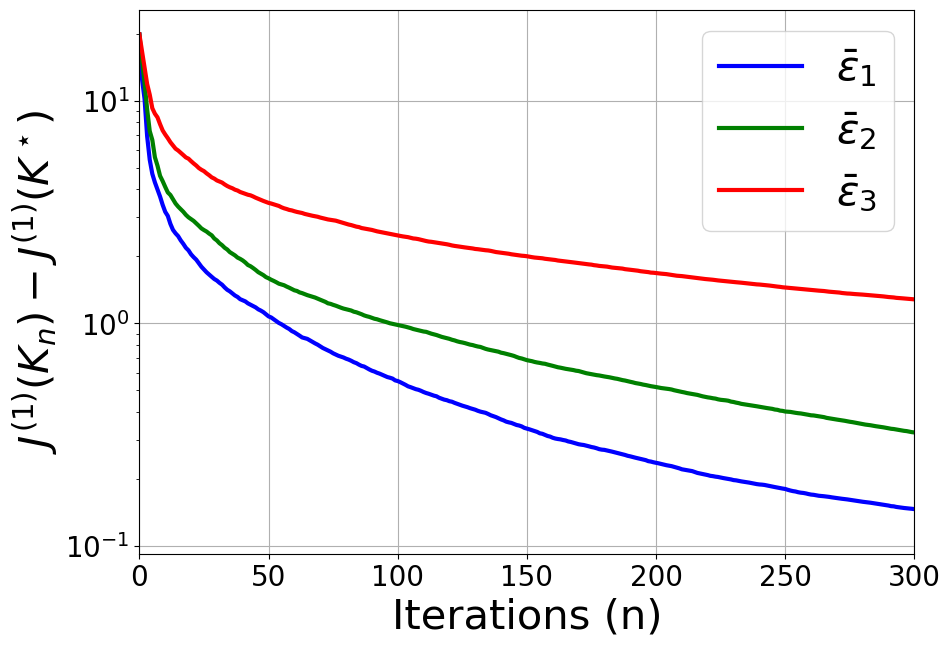

In [15]:
plt.figure(figsize=(10,8))

['eps1=', 0.019757930369961804]
['eps2=', 0.01785901437899002]
['eps3=', 0.0187513092038771]
['eps4=', 0.014492010295846494]


# Create a plot
plot_1=plt.plot(np.arange(iteration+1), costs_1, label=r'$\bar{\epsilon}_1$', color='blue',linewidth=3)
plot_2=plt.plot(np.arange(iteration+1), costs_2, label=r'$\bar{\epsilon}_2$', color='green',linewidth=3)
plot_3=plt.plot(np.arange(iteration+1), costs_3, label=r'$\bar{\epsilon}_3$', color='red', linewidth=3)

plt.ylabel(r'$J^{(1)}(K_{n})-J^{(1)}(K^\star)$',fontsize=30)
plt.xlabel('Iterations (n)',fontsize=30)
plt.tick_params(axis='both', labelsize=20)
plt.legend()
plt.semilogy()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3]  
labels = labels[:3] 
plt.legend(handles=handles, labels=labels,fontsize=30)
plt.xlim(0, 300)
# Exclude the shading elements from the legend
plt.subplots_adjust(bottom=0.20)
plt.grid()
#Save different formats
plt.savefig('MAML_het.pdf')